# MNIST Fashion Autoencoders

### Author : Ranec Belpaire

Import needed libraries

In [34]:
import keras
import numpy as np
import tensorflow as tf
import math
import cv2
from tensorflow.examples.tutorials.mnist import input_data
from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1280x960 with 0 Axes>

<Figure size 1280x960 with 0 Axes>

Import the fashion dataset provided by the keras library. The set contains 60,000 images to train the network and 10,000 test images containing various clothing items. The greyscale images have a resolution of 28x28.

In [5]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Each pixel ranges between [0,255] -> Scale and format down to a range between [0,1] for better input for the Vae
train_images = train_images / 255.0

test_images = test_images / 255.0


In [6]:
# Dictionary for labeling the images
labels_dict = {
    0: "T-shirt-top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

## Inspecting the data

In [8]:
#Get size and resolution of the images
train_size = train_images.shape[0]
test_size = test_images.shape[0]
[resX,resY] = train_images.shape[1:]
num_inputs = resX*resY

#Create big arrays containing all the images
vector_train = np.array(np.reshape(train_images, (train_size,num_inputs)), dtype = float)
vector_test = np.array(np.reshape(test_images, (test_size,num_inputs)), dtype = float)
print(f"number of training images= {train_size} " )
print(f"number of test images= {test_size} " )
print(f"Image resolution = ({resX},{resY})")

number of training images= 60000 
number of test images= 10000 
Image resolution = (28,28)


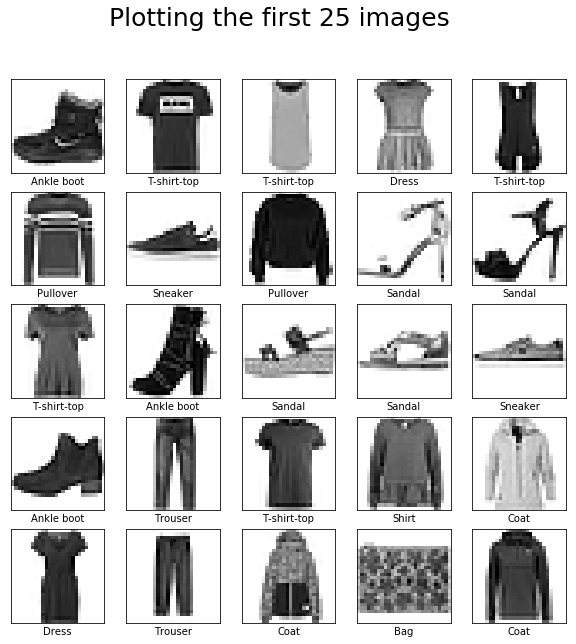

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels_dict[train_labels[i]])
fig.suptitle('Plotting the first 25 images',fontsize=25)
plt.show()

### T-SNE projection

Tool to visualise highly dimensional data in a 2D or 3D space. https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [35]:
def computeTSNEProjectionOfPixelSpace(X, display=True):
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,resX*resY*1]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne
    
# Scatter with images instead of points
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([resX,resY])
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

Computing t-SNE embedding...
Plotting t-SNE visualization...


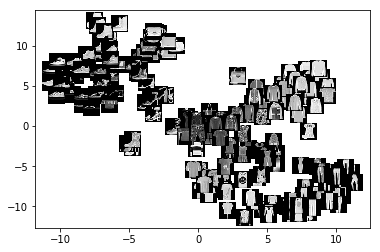

In [36]:
computeTSNEProjectionOfPixelSpace(vector_train[0:200,:])

## The Standard Autoencoder

Simple autoencoder with one hidden layer.

In [12]:
#====Autoencoder variables====#
compressionfactor= 0.5 #Compressionrate (should be between 0 and 1)
num_inputs = resX*resY  #28x28 pixels
num_encoding = math.floor((num_inputs)*compressionfactor) #Hidden layer nodes => Compressed representation
print (f"Vector size of the encoding: {num_encoding}")

Vector size of the encoding: 392


Create the input, output and hidden layer

In [14]:
##Outputs random values from a truncated normal distribution. (truncated == afgerond)
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

## Creates a constant tensor in the form of shape , containing 0.1 in each position
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

##Creates a fully connected layer
def fc_layer(previous, input_size, output_size):
    W = weight_variable([input_size, output_size])
    b = bias_variable([output_size])
    return tf.matmul(previous, W) + b

def autoencoder(x):
    l1 = tf.nn.tanh(fc_layer(x, num_inputs, num_encoding))
    l2 = tf.nn.tanh(fc_layer(l1 , num_encoding , num_encoding))
    #l3 = tf.nn.tanh(fc_layer(l2, num_encoding, num_inputs))
    out = fc_layer(l2, num_encoding, num_inputs)
    #Loss function of the normal autoencoder => Mean difference between output and initial input.
    loss = tf.reduce_mean(tf.squared_difference(x, out))
    return loss , out


### Training the network

In [17]:
epochs = 10
BATCH_SIZE = 2000

In [18]:
#Create a placeholder for the image
x = tf.placeholder(tf.float32, shape= [None, num_inputs])

#Create the autoencoder and retrieve the loss function and output
loss , out = autoencoder(x)

#Optimizer for training the network
optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

#Create a new tensorflow session
sess = tf.Session()

#Initialize the global variables
sess.run(tf.global_variables_initializer())

for epoch in range(epochs):
    epoch_loss =0        
    for i in range(int(train_size/BATCH_SIZE)):
        batch = vector_train[ i*BATCH_SIZE : (i+1)*BATCH_SIZE , : ]
        summary, train_loss = sess.run([optimizer, loss],feed_dict={x: batch})
        epoch_loss += train_loss
    print('Epoch', epoch+1 , '/', epochs, 'loss:',epoch_loss)      

Epoch 1 / 10 loss: 24.288642466068268
Epoch 2 / 10 loss: 10.802925169467926
Epoch 3 / 10 loss: 5.808691307902336
Epoch 4 / 10 loss: 3.9516588896512985
Epoch 5 / 10 loss: 3.1496662870049477
Epoch 6 / 10 loss: 2.7847067564725876
Epoch 7 / 10 loss: 2.5867891684174538
Epoch 8 / 10 loss: 2.4613636285066605
Epoch 9 / 10 loss: 2.3632674515247345
Epoch 10 / 10 loss: 2.275106444954872


### Reconstructing images

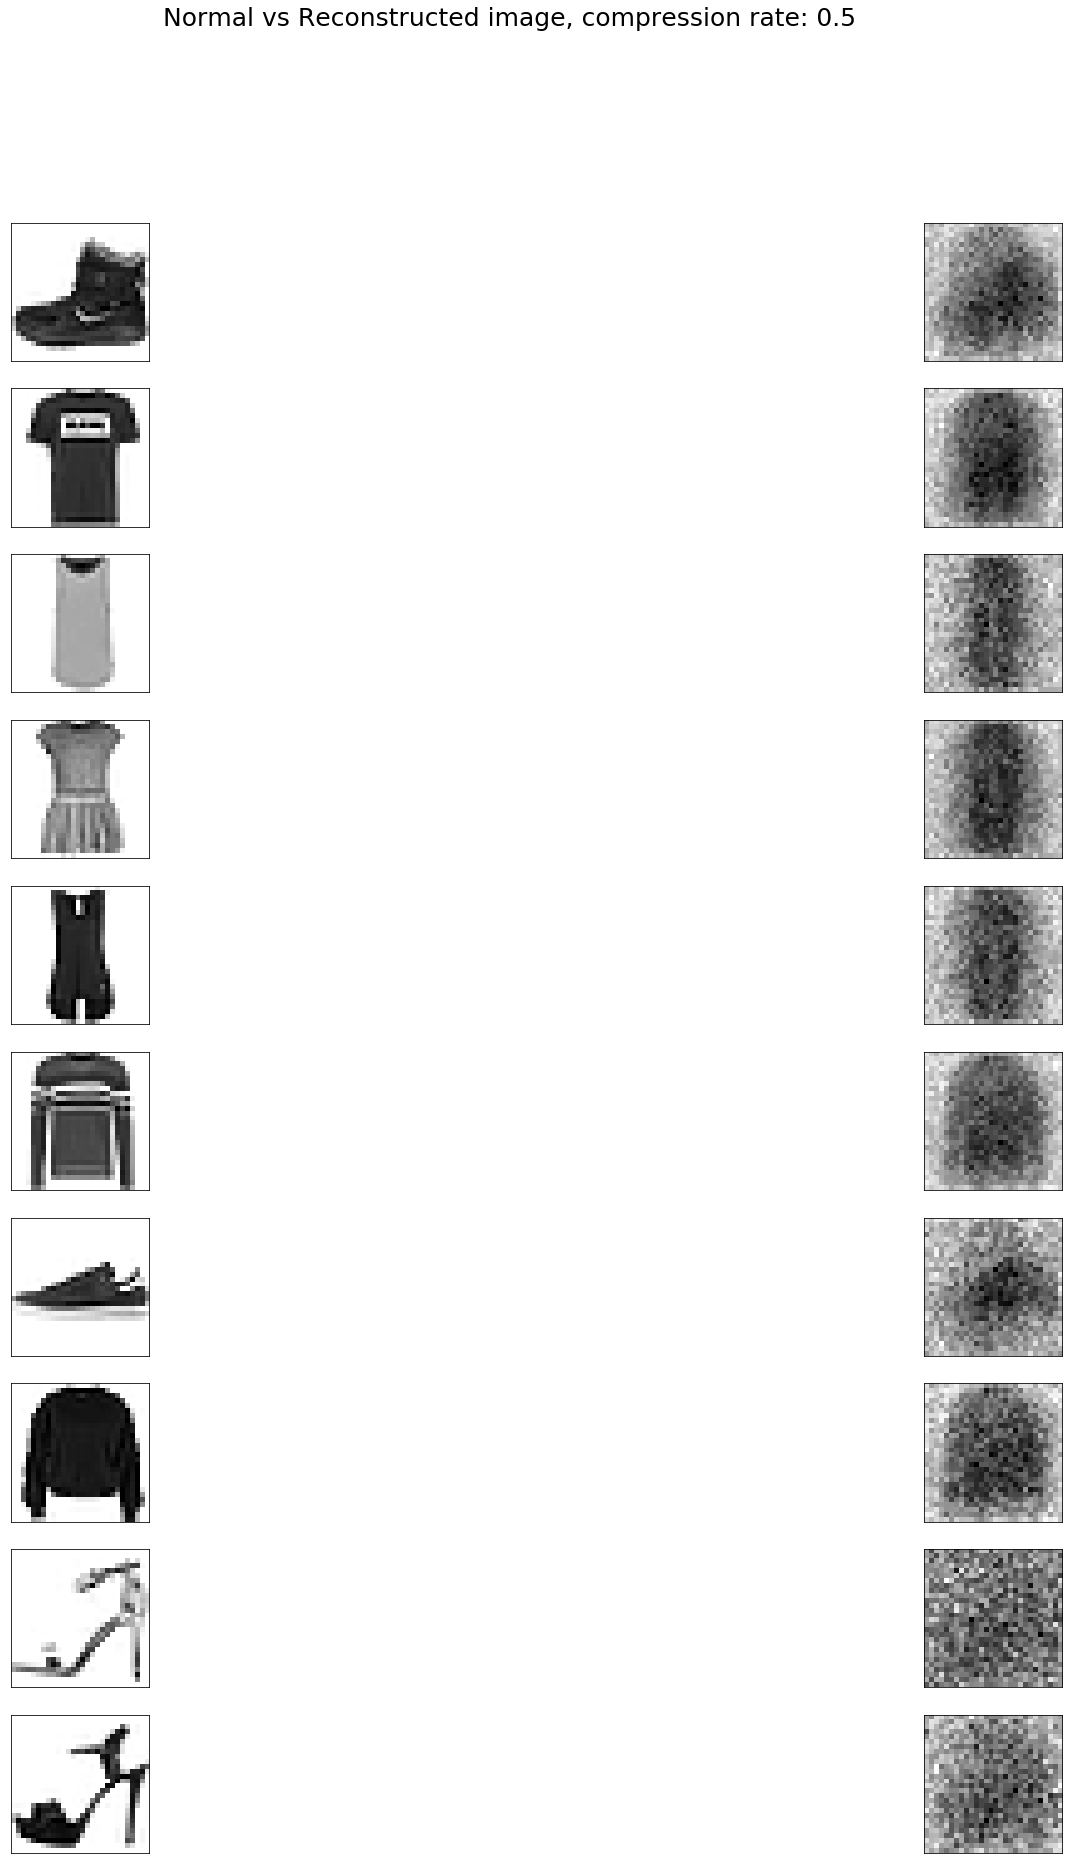

In [19]:
fig = plt.figure(figsize=(30,30))
for i in range(10):
    normal_image = vector_train[i]
    reconstructed_image = sess.run(out,feed_dict={x:[normal_image]})
    
    #Plot the normal image
    plt.subplot(10,2,(2*i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(normal_image,(resX,resY)), cmap=plt.cm.binary)
    
    #Plot the reconstructed image
    plt.subplot(10,2,(2*i)+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(reconstructed_image,(resX,resY)), cmap=plt.cm.binary)

title = 'Normal vs Reconstructed image, compression rate: ' + str(compressionfactor)
fig.suptitle(title,fontsize=25)
plt.show()

### Reconstructing images with added noise

In [20]:
#Adding noise to the images
noise = np.random.normal(0.2,0.1,(train_size , num_inputs))
noisy_imgs = vector_train + noise

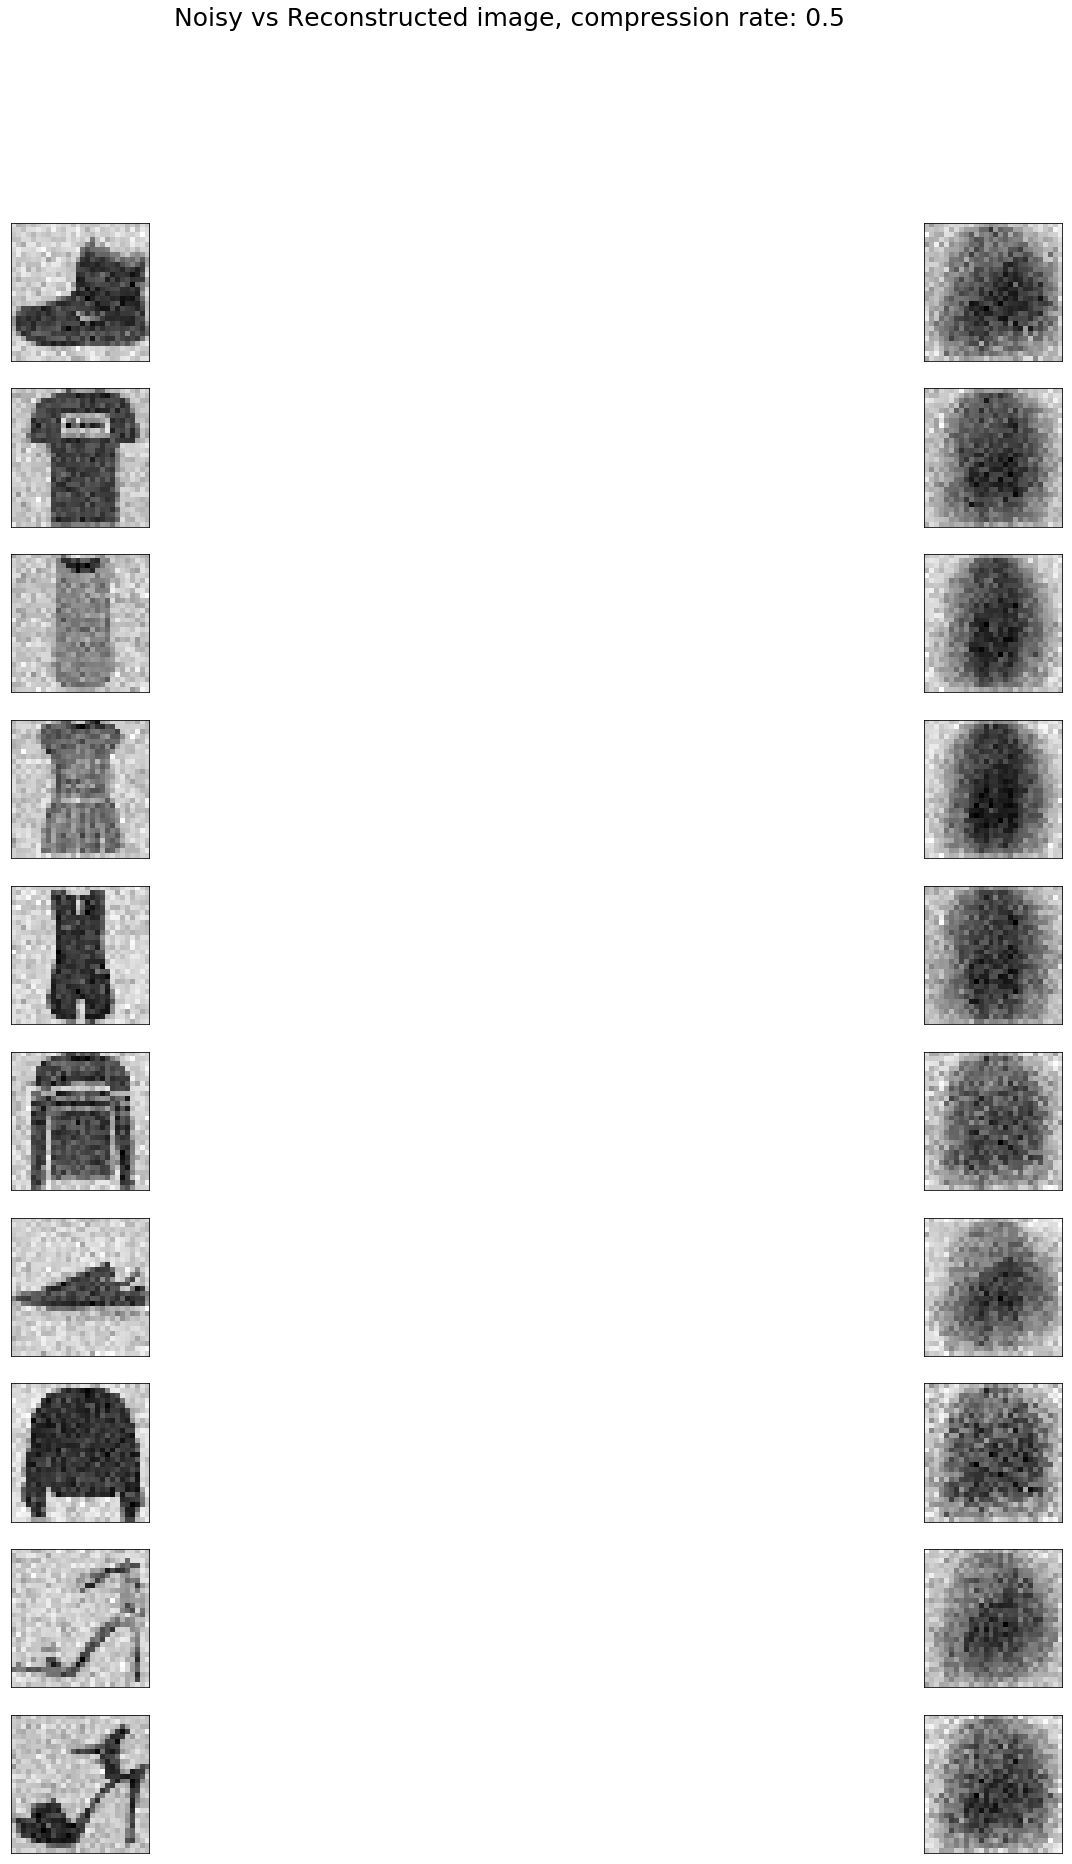

In [21]:
fig = plt.figure(figsize=(30,30))
for i in range(10):
    noisy_image = noisy_imgs[i]
    reconstructed_image = sess.run(out,feed_dict={x:[noisy_image]})
    
    #Plot the noisy image
    plt.subplot(10,2,(2*i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(noisy_image,(resX,resY)), cmap=plt.cm.binary)
    
    #Plot the reconstructed image
    plt.subplot(10,2,(2*i)+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(reconstructed_image,(resX,resY)), cmap=plt.cm.binary)

title = 'Noisy vs Reconstructed image, compression rate: ' + str(compressionfactor)
fig.suptitle(title,fontsize=25)
plt.show()

## Latent space

TODO: Plot latent space of all the images

In [23]:
#Closing the session
sess.close()

# Variational Autoencoder  -> Werkt niet!! (zie v2)

Also includes convolutional filters

In [25]:
#====Variational Autoencoder Variables====#
compressionfactor= 0.5  #Compressionrate (should be between 0 and 1)
num_inputs = resX*resY  #28x28 pixels
num_encoding = math.floor((num_inputs)*compressionfactor) #Hidden layer nodes => Compressed representation
print (f"Vector size of the encoding: {num_encoding}")


#====Architecture vars====#
X_in = tf.placeholder(dtype=tf.float32, shape=[None, resX, resY], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, resX, resY], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, num_inputs])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2

Vector size of the encoding: 392


In [11]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

def var_encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        
        # Convolutional filters
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        
        # Dense layer to the hidden representation layer with #nodes = encoding size
        mn = tf.layers.dense(x, units=num_encoding)
        sd = 0.5 * tf.layers.dense(x, units=num_encoding)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], num_encoding])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd
    
def var_decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        
        
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=num_inputs, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, resX, resY])
        return img

In [12]:
#Create the encoder and decoder
sampled, mn, sd = var_encoder(X_in, keep_prob)
dec = var_decoder(sampled, keep_prob)

#In case of error -> Restart Kernel

In [36]:
sampled
mn
sd

<tf.Tensor 'encoder/mul:0' shape=(?, 392) dtype=float32>

In [17]:
unreshaped = tf.reshape(dec, [-1, 28*28])

#Loss function for a variational autoencoder
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)



In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Training the network

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
batch_size = 64

for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    print(len(batch))
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
print(i, ls, np.mean(i_ls), np.mean(d_ls))

64


InvalidArgumentError: Input to reshape is a tensor with 3200 values, but the requested shape requires a multiple of 49
	 [[Node: decoder/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](decoder/dense_1/Maximum, decoder/Reshape/shape)]]

Caused by op 'decoder/Reshape', defined at:
  File "/home/ranec/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ranec/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-6e57c7aa3351>", line 3, in <module>
    dec = var_decoder(sampled, keep_prob)
  File "<ipython-input-11-9fd573649e0f>", line 33, in var_decoder
    x = tf.reshape(x, reshaped_dim)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6199, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/ranec/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 3200 values, but the requested shape requires a multiple of 49
	 [[Node: decoder/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](decoder/dense_1/Maximum, decoder/Reshape/shape)]]


# Variational Autoencoder v2

Functions for creating layers, Weights are initialised to xavier values, Biases are initialised to 0

In [33]:
#Returns xavier weights for the initial weights of the network.
def xavier(nin, nout):
    hi = np.sqrt( 6 / (nin + nout))
    lo = -hi
    w  = tf.random_uniform((nin, nout), minval=lo, maxval=hi, dtype= tf.float32)
    return w

#Returns a bias vector containing only zeros
def bias(nout):
    return tf.zeros([nout], dtype=tf.float32)

#Returns a layer using the input x ; name l ; number of inputs nodes nin ; number of outgoing vertices nout.
def layer(x, l, nin, nout):
    w = tf.Variable(xavier(nin, nout), name="W" + str(l))    
    b = tf.Variable(bias(nout), name= "b" + str(l))
    z = tf.matmul(x, w) + b
    return z

#Function for reversing the shape list of an architecture 
def reverse(shapes):
    x = [(o, i) for i, o in shapes]
    x.reverse()
    return x

### The encoder

Returns an architecture that outputs a mean and a signum of a normal distribution when given an input image.

In [34]:
#Creates a encoder with the given input and defined shapes
def var2_encoder(x, shapes):         
    a = x
    l = 0 # Layer number and name
    for nin, nout in shapes:
        if l == len(shapes) - 1:
            z = layer(a, l, nin, nout * 2) # In the last layer, the embedding represents the mean and variance concat
            a = tf.nn.tanh(z)
        else:            
            z = layer(a,l, nin, nout)
            a = tf.nn.relu(z)
        l += 1
    n_out = int(int(a.shape[1]) / 2)       
    mean = a[:, n_out:]
    sigm = 1e-6 + tf.nn.softplus(a[:, :n_out])
    return (mean, sigm)

### The decoder

Returns an architecture that outputs the recreated image using the sampled representation

In [35]:
#Creates a decoder with the given input and defined shapes
def var2_decoder(x, shapes):         
    a = x
    l = 0
    for nin, nout in shapes:     
        z = layer(a, l, nin, nout)
        if l == 0:
            a = tf.nn.tanh(z)
        elif l == len(shapes) - 1:
            a = tf.nn.sigmoid(z)
        else:            
            a = tf.nn.relu(z)
        l += 1
    return a

### The Variational Autoencoder and The Loss Function

In [36]:
def vae(x, enc_shapes, dec_shapes):
    #Create the encoder and feed the input and shapes
    mu, sigm = var2_encoder(x, enc_shapes)
    
    #Sampling using the re-parametrisation technique
    sample = mu + sigm * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
    
    #Create the decoder and feed the sampled representation and architecture shape
    y = var2_decoder(sample, dec_shapes)
    
    # Loss function #
    
    #Marginal_likelihood: Mistakes in decoding will be penalized
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    
    #KL_divergence: Forces the distribution to a normal distribution N(0,1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigm) - tf.log(1e-8 + tf.square(sigm)) - 1, 1)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence
    loss = -ELBO
    
    return y, sample, loss, -marginal_likelihood, KL_divergence

## Training the network

In [58]:
#====Shape of the network====#

#Autoencoder shape
enc_shapes = [
    (784, 512),
    (512, 256),
    (256, 128)
]
#Decoder architecture is the reversed encoder architecture
dec_shapes = reverse(enc_shapes)

#====Training variables====#

#Learning rate
rate = 0.001
#Batch size
batch_size = 100
#Total batches
total_batch = int(train_size / batch_size)
#Epochs
epochs = 5

#Seed
np.random.seed(0)
tf.set_random_seed(0)

#Placeholder for the image
input_layer = tf.placeholder(tf.float32, shape=(None, num_inputs))

In [59]:
#Create the VAE
y, z, loss, neg_marginal_likelihood, KL_divergence = vae(input_layer, enc_shapes, dec_shapes)

#Optimizer for the loss function
train_op = tf.train.AdamOptimizer(rate).minimize(loss)

In [60]:
#Create a new tensorflow session
sess = tf.Session()
#Initialise global variables
sess.run(tf.global_variables_initializer())

# training
print("Learning: ")

for epoch in range(epochs):
    total_loss = 0.0
    loss_lik   = 0.0
    loss_div   = 0.0
    for i in range(0, total_batch):
        batch = vector_train[ i*batch_size : (i+1)*batch_size , : ]
        _, tot_loss, loss_likelihood, loss_divergence = sess.run(
            (train_op, loss, neg_marginal_likelihood, KL_divergence),
            feed_dict={ input_layer: batch }
        )
        total_loss += tot_loss
        loss_lik   += loss_likelihood
        loss_div   += loss_divergence
    print('Epoch', epoch+1 , '/', epochs, 'loss:',total_loss)   

Learning: 
Epoch 1 / 5 loss: 175428.62506103516
Epoch 2 / 5 loss: 162015.8152923584
Epoch 3 / 5 loss: 158158.15739440918
Epoch 4 / 5 loss: 155625.41850280762
Epoch 5 / 5 loss: 153974.0274658203


In [ ]:
# creating reconstruction from test images
print("Reconstruction: ")
(images, labels) = (data.test.next_batch(100))
a = 0
b = 0
latent_img = []
for i in range(0, 100):
    print(" - reconstructing: " + labels_dict[labels[i]], a, b, i)
    y_out, u    = sess.run((y, z), feed_dict={input_layer: images[i].reshape(1, 784)})
    y_img       = y_out.reshape(28, 28)
    latent_img += [(y_img, labels_dict[labels[i]])]
latent_img = sorted(latent_img, key = lambda x : x[1])

# plotting
print("Plotting")
f, axarr = plt.subplots(10, 10)
for i in range(0, 100):        
    if a == 10:
        a = 0
        b += 1

    axarr[a, b].set_title(latent_img[i][1])
    axarr[a, b].imshow(latent_img[i][0], cmap=plt.get_cmap('gray'))  
    a += 1

f.subplots_adjust(hspace = 0.7)
f.set_size_inches(25.0, 25.0, forward=True)
plt.savefig("result/prediction.png")        

print("Done")

In [ ]:
fig = plt.figure(figsize=(30,30))
for i in range(10):
    normal_image = vector_train[i]
    reconstructed_image = sess.run(y , feed_dict={input_layer: [normal_image]})
    #Plot the normal image
    plt.subplot(10,2,(2*i)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(normal_image,(resX,resY)), cmap=plt.cm.binary)
    
    #Plot the reconstructed image
    plt.subplot(10,2,(2*i)+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(reconstructed_image,(resX,resY)), cmap=plt.cm.binary)

title = 'Normal vs Reconstructed image, compression rate: ' + str(compressionfactor)
fig.suptitle(title,fontsize=25)
plt.show()